Lien de téléchargement des données: https://cvml.ista.ac.at/AwA2/        

13GB file : https://cvml.ista.ac.at/AwA2/AwA2-data.zip

In [1]:
# !pip install wandb -qU

In [2]:
# Log in to your W&B account
import wandb
wandb.login()

wandb: Currently logged in as: yanzhang7271 (-yanzhang). Use `wandb login --relogin` to force relogin


True

In [3]:
# wandb: Currently logged in as: yanzhang7271 (-yanzhang). Use `wandb login --relogin` to force relogin
# pip install wandb

In [4]:
import sys
import cv2 # Pour utiliser open_cv, il faut la version de python est 3.7
import os
import csv

import numpy as np 
import pandas as pd 
import math

import torch 
from torch.utils.data import Dataset, DataLoader
import torchvision 
from torchvision.io import read_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler


import matplotlib.pyplot as plt

np.random.seed(0)

In [5]:
import wandb

In [6]:
# Constant. Should be the path to the folder named JPEGImages, containing the 33K images in its subfolders.
JPEGIMAGES_FOLDER_PATH = "C:/Users/1/Desktop/data_ift3710/Animals_with_Attributes2/JPEGImages/"
path_project = "C:/Users/1/Desktop/data_ift3710/Animals_with_Attributes2/"

In [7]:
labels_dirs = os.listdir(JPEGIMAGES_FOLDER_PATH)
print(labels_dirs)
len(labels_dirs) # 50 labels / subdirectories

['antelope', 'bat', 'beaver', 'blue+whale', 'bobcat', 'buffalo', 'chihuahua', 'chimpanzee', 'collie', 'cow', 'dalmatian', 'deer', 'dolphin', 'elephant', 'fox', 'german+shepherd', 'giant+panda', 'giraffe', 'gorilla', 'grizzly+bear', 'hamster', 'hippopotamus', 'horse', 'humpback+whale', 'killer+whale', 'leopard', 'lion', 'mole', 'moose', 'mouse', 'otter', 'ox', 'persian+cat', 'pig', 'polar+bear', 'rabbit', 'raccoon', 'rat', 'rhinoceros', 'seal', 'sheep', 'siamese+cat', 'skunk', 'spider+monkey', 'squirrel', 'tiger', 'walrus', 'weasel', 'wolf', 'zebra']


50

In [8]:
def get_num_label(label):
    return labels_dirs.index(labels_dirs)

# Note : Some labels have a low number of images. 

## Possible solutions to explore : 
    Data augmentation : creating new training data by applying random transformations to existing images, such as rotating, cropping, or flipping them.

In [9]:
def find_num_images_per_label(img_dir = JPEGIMAGES_FOLDER_PATH): 
    """ 
    USEFUL FOR SAMPLING.
    Return a dict with keys as the 50 labels, and values being the number of images in each subdirectory corresponding to label
    and a second dict with the relative numbers (proportion) for every label compared to the total number of images (useful for sampling)"""
    labels_dirs = os.listdir(img_dir)
    num_images_per_label = dict.fromkeys(labels_dirs)
    proportions_images_per_label = dict.fromkeys(labels_dirs)
    total_num_images = 0

    # Update absolute number of images per label
    for i, label in enumerate(labels_dirs) : 
        specific_label_path = os.path.join(img_dir, labels_dirs[i])
        num_images_label = len(os.listdir(specific_label_path))
        total_num_images += num_images_label
        num_images_per_label[label] = num_images_label

    # Update relative number of images per label (proportion)
    for i, label in enumerate(labels_dirs) : 
        num_images_label = num_images_per_label[label]
        proportion_label = round(num_images_label / total_num_images, 4)
        proportions_images_per_label[label] = proportion_label

    return num_images_per_label, proportions_images_per_label

num_images_per_label, proportions_images_per_label = find_num_images_per_label()

In [10]:
ANNOTATIONS_FILENAME = 'annotations.csv'

def create_annotations_csv_file(annotations_filename = ANNOTATIONS_FILENAME, img_dir = JPEGIMAGES_FOLDER_PATH) : 
    """ 
    Create a csv annotations_file, annotations.csv, with two columns, in the format : 
                        path/to/image, label
    
    The annotation csv is necessary for DataLoader.
    """

    labels_dirs:list = os.listdir(img_dir)
   
    if os.path.exists(annotations_filename):
        os.remove(annotations_filename)
        print(f'Deleted existent {ANNOTATIONS_FILENAME} file.\n ---------------------------')
    
    with open(annotations_filename, 'w', newline='') as file :
        writer = csv.writer(file, dialect='excel', delimiter=',')

        for i, label in enumerate(labels_dirs) : 

            specific_label_path = os.path.join(img_dir, label)
            images_names = os.listdir(specific_label_path)

            for j, image_name in enumerate(images_names):
                full_path_to_img= os.path.join(specific_label_path, image_name)
                full_path_to_img= os.path.join(label, image_name)

                row = [full_path_to_img, label]
                writer.writerow(row)

    print(f'Sucessfully created {ANNOTATIONS_FILENAME} file.')

#
create_annotations_csv_file()

Deleted existent annotations.csv file.
 ---------------------------
Sucessfully created annotations.csv file.


In [11]:
class AWA2Dataset(Dataset): # Dataset class to serve as input for the DataLoader.
    """ 
    Dataset class to serve as input for the DataLoader.
    Implements all the required methods and more. 
    """

    def __init__(self, annotations_file=ANNOTATIONS_FILENAME, img_dir=JPEGIMAGES_FOLDER_PATH, 
                transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        numbers_infos_dicts: tuple[dict,dict] = find_num_images_per_label(img_dir=JPEGIMAGES_FOLDER_PATH)
        self.num_images_per_label = numbers_infos_dicts[0]
        self.proportions_images_per_label = numbers_infos_dicts[1]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # img_path = self.img_labels.iloc[idx, 0]
        label = self.img_labels.iloc[idx, 1]

        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [12]:
dataset = AWA2Dataset()

## TODO : Change transforms. Currently this is not useful.
dataset.transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize((256,256)),
                    transforms.CenterCrop((224,224)),
                    transforms.Grayscale(num_output_channels=3),
                    transforms.ToTensor(), # Already a tensor as implemented in Dataset class with the reaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])

# Testing. All good
random_index = np.random.randint(0, len(dataset))
image, label = dataset[random_index]

In [13]:
# Experiment with DataLoader. Everything works good
dataloader = DataLoader(dataset = dataset, batch_size=16, shuffle=True)
dataiter = iter(dataloader)
data = next(dataiter)

images, labels = data 


###   AlexNet  ###

In [14]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=False)

#Model description
AlexNet_model.eval()

Using cache found in C:\Users\1/.cache\torch\hub\pytorch_vision_v0.6.0
D:\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### CUDA ###

In [15]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [16]:
torch.cuda.is_available()

True

### Question: nombre de noeud ###

In [17]:
nb_noeud = 4096

In [18]:
AlexNet_model.classifier[4] = torch.nn.Linear(4096,nb_noeud)
AlexNet_model.classifier[6] = torch.nn.Linear(nb_noeud,50)

In [19]:
import sys
print(sys.version)

3.8.16 (default, Mar  2 2023, 03:18:16) [MSC v.1916 64 bit (AMD64)]


In [20]:
AlexNet_model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Question: check dimension de dataloader   ###

###  Split training data and test data ###

In [21]:
batch_size = 128

In [22]:
dataloader = DataLoader(dataset = dataset, batch_size=batch_size, shuffle=True)
train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size

In [23]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset,[train_size,test_size])

In [24]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=0)

###   transfomer labels  ###

In [25]:
path_class = path_project +"classes.txt"
class_animal = pd.read_table(path_class,header= None)

In [26]:
animals = class_animal[1]

In [27]:
dict_label_animal = {}

In [28]:
n = 0
for i in range(0,len(animals)):
    dict_label_animal[animals[i]] = n
    n+=1

In [29]:
def label_to_num(tuple_labels):
    list_labels =[]
    for tuple_label in tuple_labels:
        list_labels.append(dict_label_animal[tuple_label])
    return torch.tensor(list_labels)   

###   Loss function  ###

In [30]:
lr = 0.0001

In [31]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(AlexNet_model.parameters(), lr= lr)

In [32]:
torch.cuda.empty_cache()

###  Training  ###

In [33]:
wandb.init(
    # set the wandb project where this run will be logged
    project="AlexNet",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "AlexNet",
    "dataset": "AWA2",
    "epochs": 20,
    }
)

for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data[0].to(device)
        labels = label_to_num(data[1]).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss ))
        
        # acc
        print('current batch acc', (labels == output.argmax(dim=1)[0]).int().sum() / labels.size(0))
        
        # log metrics to wandb
        wandb.log({"loss": running_loss, "acc": (labels == output.argmax(dim=1)[0]).int().sum() / labels.size(0)})
        
        running_loss = 0.0

print('Finished Training of AlexNet')

[1,     1] loss: 3.912
current batch acc tensor(0., device='cuda:0')
[1,     2] loss: 3.905
current batch acc tensor(0.0312, device='cuda:0')
[1,     3] loss: 3.894
current batch acc tensor(0.0312, device='cuda:0')
[1,     4] loss: 3.880
current batch acc tensor(0.0312, device='cuda:0')
[1,     5] loss: 3.804
current batch acc tensor(0.0547, device='cuda:0')
[1,     6] loss: 3.880
current batch acc tensor(0.0312, device='cuda:0')
[1,     7] loss: 3.801
current batch acc tensor(0.0391, device='cuda:0')
[1,     8] loss: 3.802
current batch acc tensor(0.0625, device='cuda:0')
[1,     9] loss: 3.794
current batch acc tensor(0.0547, device='cuda:0')
[1,    10] loss: 3.865
current batch acc tensor(0.0234, device='cuda:0')
[1,    11] loss: 3.813
current batch acc tensor(0.0156, device='cuda:0')
[1,    12] loss: 3.790
current batch acc tensor(0.0156, device='cuda:0')
[1,    13] loss: 3.793
current batch acc tensor(0.0625, device='cuda:0')
[1,    14] loss: 3.842
current batch acc tensor(0.0391,

[1,   114] loss: 3.526
current batch acc tensor(0., device='cuda:0')
[1,   115] loss: 3.350
current batch acc tensor(0.0312, device='cuda:0')
[1,   116] loss: 3.264
current batch acc tensor(0.0234, device='cuda:0')
[1,   117] loss: 3.444
current batch acc tensor(0.0312, device='cuda:0')
[1,   118] loss: 3.417
current batch acc tensor(0.0234, device='cuda:0')
[1,   119] loss: 3.370
current batch acc tensor(0.0312, device='cuda:0')
[1,   120] loss: 3.461
current batch acc tensor(0.0156, device='cuda:0')
[1,   121] loss: 3.387
current batch acc tensor(0.0156, device='cuda:0')
[1,   122] loss: 3.454
current batch acc tensor(0.0234, device='cuda:0')
[1,   123] loss: 3.377
current batch acc tensor(0.0078, device='cuda:0')
[1,   124] loss: 3.565
current batch acc tensor(0.0312, device='cuda:0')
[1,   125] loss: 3.414
current batch acc tensor(0.0391, device='cuda:0')
[1,   126] loss: 3.483
current batch acc tensor(0.0078, device='cuda:0')
[1,   127] loss: 3.312
current batch acc tensor(0.0469,

[1,   227] loss: 3.228
current batch acc tensor(0.0391, device='cuda:0')
[1,   228] loss: 3.100
current batch acc tensor(0.0156, device='cuda:0')
[1,   229] loss: 3.039
current batch acc tensor(0.0234, device='cuda:0')
[1,   230] loss: 3.118
current batch acc tensor(0.0234, device='cuda:0')
[1,   231] loss: 3.132
current batch acc tensor(0.0234, device='cuda:0')
[1,   232] loss: 3.208
current batch acc tensor(0.0391, device='cuda:0')
[1,   233] loss: 3.066
current batch acc tensor(0.0156, device='cuda:0')
[1,   234] loss: 3.397
current batch acc tensor(0.0312, device='cuda:0')
[2,     1] loss: 3.251
current batch acc tensor(0.0469, device='cuda:0')
[2,     2] loss: 2.972
current batch acc tensor(0.0156, device='cuda:0')
[2,     3] loss: 3.346
current batch acc tensor(0.0312, device='cuda:0')
[2,     4] loss: 3.116
current batch acc tensor(0.0391, device='cuda:0')
[2,     5] loss: 3.009
current batch acc tensor(0.0391, device='cuda:0')
[2,     6] loss: 3.009
current batch acc tensor(0.0

[2,   106] loss: 3.000
current batch acc tensor(0.0078, device='cuda:0')
[2,   107] loss: 2.797
current batch acc tensor(0.0156, device='cuda:0')
[2,   108] loss: 3.029
current batch acc tensor(0.0391, device='cuda:0')
[2,   109] loss: 3.214
current batch acc tensor(0.0312, device='cuda:0')
[2,   110] loss: 3.053
current batch acc tensor(0.0312, device='cuda:0')
[2,   111] loss: 2.946
current batch acc tensor(0.0078, device='cuda:0')
[2,   112] loss: 2.979
current batch acc tensor(0.0469, device='cuda:0')
[2,   113] loss: 2.800
current batch acc tensor(0.0469, device='cuda:0')
[2,   114] loss: 3.006
current batch acc tensor(0.0234, device='cuda:0')
[2,   115] loss: 2.858
current batch acc tensor(0.0156, device='cuda:0')
[2,   116] loss: 2.760
current batch acc tensor(0.0312, device='cuda:0')
[2,   117] loss: 2.953
current batch acc tensor(0.0469, device='cuda:0')
[2,   118] loss: 2.790
current batch acc tensor(0.0078, device='cuda:0')
[2,   119] loss: 2.824
current batch acc tensor(0.0

[2,   219] loss: 2.689
current batch acc tensor(0.0312, device='cuda:0')
[2,   220] loss: 2.815
current batch acc tensor(0.0391, device='cuda:0')
[2,   221] loss: 2.931
current batch acc tensor(0.0234, device='cuda:0')
[2,   222] loss: 2.662
current batch acc tensor(0.0312, device='cuda:0')
[2,   223] loss: 2.681
current batch acc tensor(0.0312, device='cuda:0')
[2,   224] loss: 2.520
current batch acc tensor(0.0391, device='cuda:0')
[2,   225] loss: 2.716
current batch acc tensor(0.0156, device='cuda:0')
[2,   226] loss: 2.522
current batch acc tensor(0.0078, device='cuda:0')
[2,   227] loss: 2.672
current batch acc tensor(0.0078, device='cuda:0')
[2,   228] loss: 2.713
current batch acc tensor(0.0234, device='cuda:0')
[2,   229] loss: 2.443
current batch acc tensor(0.0391, device='cuda:0')
[2,   230] loss: 2.712
current batch acc tensor(0.0234, device='cuda:0')
[2,   231] loss: 2.650
current batch acc tensor(0.0312, device='cuda:0')
[2,   232] loss: 2.716
current batch acc tensor(0.0

[3,    98] loss: 2.543
current batch acc tensor(0.0078, device='cuda:0')
[3,    99] loss: 2.717
current batch acc tensor(0.0703, device='cuda:0')
[3,   100] loss: 2.482
current batch acc tensor(0.0234, device='cuda:0')
[3,   101] loss: 2.424
current batch acc tensor(0.0312, device='cuda:0')
[3,   102] loss: 2.416
current batch acc tensor(0.0234, device='cuda:0')
[3,   103] loss: 2.745
current batch acc tensor(0.0234, device='cuda:0')
[3,   104] loss: 2.557
current batch acc tensor(0.0234, device='cuda:0')
[3,   105] loss: 2.435
current batch acc tensor(0.0625, device='cuda:0')
[3,   106] loss: 2.707
current batch acc tensor(0.0234, device='cuda:0')
[3,   107] loss: 2.367
current batch acc tensor(0.0234, device='cuda:0')
[3,   108] loss: 2.678
current batch acc tensor(0.0391, device='cuda:0')
[3,   109] loss: 2.993
current batch acc tensor(0.0391, device='cuda:0')
[3,   110] loss: 2.734
current batch acc tensor(0.0625, device='cuda:0')
[3,   111] loss: 2.763
current batch acc tensor(0.0

[3,   211] loss: 2.326
current batch acc tensor(0.0312, device='cuda:0')
[3,   212] loss: 2.354
current batch acc tensor(0.0312, device='cuda:0')
[3,   213] loss: 2.571
current batch acc tensor(0.0625, device='cuda:0')
[3,   214] loss: 2.223
current batch acc tensor(0.0234, device='cuda:0')
[3,   215] loss: 2.333
current batch acc tensor(0.0391, device='cuda:0')
[3,   216] loss: 2.419
current batch acc tensor(0.0391, device='cuda:0')
[3,   217] loss: 2.678
current batch acc tensor(0.0234, device='cuda:0')
[3,   218] loss: 2.275
current batch acc tensor(0.0312, device='cuda:0')
[3,   219] loss: 2.467
current batch acc tensor(0.0312, device='cuda:0')
[3,   220] loss: 2.499
current batch acc tensor(0.0469, device='cuda:0')
[3,   221] loss: 2.620
current batch acc tensor(0.0234, device='cuda:0')
[3,   222] loss: 2.396
current batch acc tensor(0.0312, device='cuda:0')
[3,   223] loss: 2.346
current batch acc tensor(0.0156, device='cuda:0')
[3,   224] loss: 2.298
current batch acc tensor(0.0

[4,    90] loss: 2.180
current batch acc tensor(0.0469, device='cuda:0')
[4,    91] loss: 2.285
current batch acc tensor(0.0312, device='cuda:0')
[4,    92] loss: 2.214
current batch acc tensor(0.0156, device='cuda:0')
[4,    93] loss: 2.325
current batch acc tensor(0.0312, device='cuda:0')
[4,    94] loss: 2.100
current batch acc tensor(0.0625, device='cuda:0')
[4,    95] loss: 2.367
current batch acc tensor(0.0078, device='cuda:0')
[4,    96] loss: 2.358
current batch acc tensor(0.0078, device='cuda:0')
[4,    97] loss: 2.355
current batch acc tensor(0.0625, device='cuda:0')
[4,    98] loss: 2.220
current batch acc tensor(0.0078, device='cuda:0')
[4,    99] loss: 2.436
current batch acc tensor(0.0703, device='cuda:0')
[4,   100] loss: 2.341
current batch acc tensor(0.0156, device='cuda:0')
[4,   101] loss: 2.094
current batch acc tensor(0.0312, device='cuda:0')
[4,   102] loss: 2.102
current batch acc tensor(0.0547, device='cuda:0')
[4,   103] loss: 2.463
current batch acc tensor(0.0

[4,   203] loss: 1.995
current batch acc tensor(0.0156, device='cuda:0')
[4,   204] loss: 2.226
current batch acc tensor(0.0234, device='cuda:0')
[4,   205] loss: 2.488
current batch acc tensor(0.0312, device='cuda:0')
[4,   206] loss: 2.173
current batch acc tensor(0.0391, device='cuda:0')
[4,   207] loss: 2.124
current batch acc tensor(0.0156, device='cuda:0')
[4,   208] loss: 2.013
current batch acc tensor(0.0469, device='cuda:0')
[4,   209] loss: 2.068
current batch acc tensor(0.0469, device='cuda:0')
[4,   210] loss: 2.244
current batch acc tensor(0.0391, device='cuda:0')
[4,   211] loss: 2.157
current batch acc tensor(0., device='cuda:0')
[4,   212] loss: 2.102
current batch acc tensor(0.0312, device='cuda:0')
[4,   213] loss: 2.260
current batch acc tensor(0.0312, device='cuda:0')
[4,   214] loss: 1.997
current batch acc tensor(0.0234, device='cuda:0')
[4,   215] loss: 2.127
current batch acc tensor(0.0312, device='cuda:0')
[4,   216] loss: 2.252
current batch acc tensor(0.0078,

[5,    82] loss: 1.891
current batch acc tensor(0.0078, device='cuda:0')
[5,    83] loss: 1.883
current batch acc tensor(0.0625, device='cuda:0')
[5,    84] loss: 2.033
current batch acc tensor(0.0312, device='cuda:0')
[5,    85] loss: 2.216
current batch acc tensor(0.0391, device='cuda:0')
[5,    86] loss: 1.914
current batch acc tensor(0.0156, device='cuda:0')
[5,    87] loss: 2.165
current batch acc tensor(0.0312, device='cuda:0')
[5,    88] loss: 1.971
current batch acc tensor(0.0312, device='cuda:0')
[5,    89] loss: 2.035
current batch acc tensor(0.0703, device='cuda:0')
[5,    90] loss: 1.952
current batch acc tensor(0.0391, device='cuda:0')
[5,    91] loss: 1.966
current batch acc tensor(0.0312, device='cuda:0')
[5,    92] loss: 1.979
current batch acc tensor(0.0156, device='cuda:0')
[5,    93] loss: 2.127
current batch acc tensor(0.0312, device='cuda:0')
[5,    94] loss: 1.861
current batch acc tensor(0.0469, device='cuda:0')
[5,    95] loss: 2.141
current batch acc tensor(0.0

[5,   195] loss: 1.956
current batch acc tensor(0.0391, device='cuda:0')
[5,   196] loss: 1.816
current batch acc tensor(0.0391, device='cuda:0')
[5,   197] loss: 1.685
current batch acc tensor(0.0547, device='cuda:0')
[5,   198] loss: 1.848
current batch acc tensor(0.0156, device='cuda:0')
[5,   199] loss: 2.137
current batch acc tensor(0.0312, device='cuda:0')
[5,   200] loss: 1.957
current batch acc tensor(0.0234, device='cuda:0')
[5,   201] loss: 2.072
current batch acc tensor(0.0547, device='cuda:0')
[5,   202] loss: 1.999
current batch acc tensor(0.0312, device='cuda:0')
[5,   203] loss: 1.758
current batch acc tensor(0.0156, device='cuda:0')
[5,   204] loss: 2.016
current batch acc tensor(0.0156, device='cuda:0')
[5,   205] loss: 2.218
current batch acc tensor(0.0312, device='cuda:0')
[5,   206] loss: 1.893
current batch acc tensor(0.0391, device='cuda:0')
[5,   207] loss: 2.002
current batch acc tensor(0.0156, device='cuda:0')
[5,   208] loss: 1.833
current batch acc tensor(0.0

[6,    74] loss: 1.712
current batch acc tensor(0.0547, device='cuda:0')
[6,    75] loss: 2.132
current batch acc tensor(0.0469, device='cuda:0')
[6,    76] loss: 1.669
current batch acc tensor(0.0547, device='cuda:0')
[6,    77] loss: 1.710
current batch acc tensor(0.0234, device='cuda:0')
[6,    78] loss: 1.760
current batch acc tensor(0.0156, device='cuda:0')
[6,    79] loss: 1.824
current batch acc tensor(0.0234, device='cuda:0')
[6,    80] loss: 1.766
current batch acc tensor(0.0312, device='cuda:0')
[6,    81] loss: 1.851
current batch acc tensor(0.0078, device='cuda:0')
[6,    82] loss: 1.727
current batch acc tensor(0.0078, device='cuda:0')
[6,    83] loss: 1.715
current batch acc tensor(0.0625, device='cuda:0')
[6,    84] loss: 1.788
current batch acc tensor(0.0156, device='cuda:0')
[6,    85] loss: 1.896
current batch acc tensor(0.0391, device='cuda:0')
[6,    86] loss: 1.674
current batch acc tensor(0.0156, device='cuda:0')
[6,    87] loss: 1.972
current batch acc tensor(0.0

[6,   187] loss: 1.841
current batch acc tensor(0.0391, device='cuda:0')
[6,   188] loss: 1.725
current batch acc tensor(0.0234, device='cuda:0')
[6,   189] loss: 1.898
current batch acc tensor(0.0078, device='cuda:0')
[6,   190] loss: 1.854
current batch acc tensor(0.0391, device='cuda:0')
[6,   191] loss: 1.489
current batch acc tensor(0.0156, device='cuda:0')
[6,   192] loss: 1.584
current batch acc tensor(0.0547, device='cuda:0')
[6,   193] loss: 1.922
current batch acc tensor(0., device='cuda:0')
[6,   194] loss: 1.585
current batch acc tensor(0.0234, device='cuda:0')
[6,   195] loss: 1.823
current batch acc tensor(0., device='cuda:0')
[6,   196] loss: 1.633
current batch acc tensor(0.0391, device='cuda:0')
[6,   197] loss: 1.371
current batch acc tensor(0.0547, device='cuda:0')
[6,   198] loss: 1.554
current batch acc tensor(0.0156, device='cuda:0')
[6,   199] loss: 2.041
current batch acc tensor(0.0312, device='cuda:0')
[6,   200] loss: 1.728
current batch acc tensor(0.0703, dev

[7,    66] loss: 1.445
current batch acc tensor(0.0156, device='cuda:0')
[7,    67] loss: 1.633
current batch acc tensor(0.0234, device='cuda:0')
[7,    68] loss: 1.752
current batch acc tensor(0.0234, device='cuda:0')
[7,    69] loss: 1.509
current batch acc tensor(0.0391, device='cuda:0')
[7,    70] loss: 1.349
current batch acc tensor(0.0312, device='cuda:0')
[7,    71] loss: 1.544
current batch acc tensor(0.0469, device='cuda:0')
[7,    72] loss: 1.308
current batch acc tensor(0.0391, device='cuda:0')
[7,    73] loss: 1.428
current batch acc tensor(0.0234, device='cuda:0')
[7,    74] loss: 1.387
current batch acc tensor(0.0547, device='cuda:0')
[7,    75] loss: 1.847
current batch acc tensor(0.0469, device='cuda:0')
[7,    76] loss: 1.403
current batch acc tensor(0.0234, device='cuda:0')
[7,    77] loss: 1.383
current batch acc tensor(0.0234, device='cuda:0')
[7,    78] loss: 1.549
current batch acc tensor(0.0312, device='cuda:0')
[7,    79] loss: 1.525
current batch acc tensor(0.0

[7,   179] loss: 1.577
current batch acc tensor(0.0312, device='cuda:0')
[7,   180] loss: 1.470
current batch acc tensor(0.0234, device='cuda:0')
[7,   181] loss: 1.629
current batch acc tensor(0.0391, device='cuda:0')
[7,   182] loss: 1.440
current batch acc tensor(0.0312, device='cuda:0')
[7,   183] loss: 1.619
current batch acc tensor(0.0312, device='cuda:0')
[7,   184] loss: 1.247
current batch acc tensor(0.0469, device='cuda:0')
[7,   185] loss: 1.433
current batch acc tensor(0.0234, device='cuda:0')
[7,   186] loss: 1.629
current batch acc tensor(0.0156, device='cuda:0')
[7,   187] loss: 1.609
current batch acc tensor(0.0391, device='cuda:0')
[7,   188] loss: 1.419
current batch acc tensor(0.0234, device='cuda:0')
[7,   189] loss: 1.458
current batch acc tensor(0.0469, device='cuda:0')
[7,   190] loss: 1.484
current batch acc tensor(0.0391, device='cuda:0')
[7,   191] loss: 1.330
current batch acc tensor(0.0312, device='cuda:0')
[7,   192] loss: 1.405
current batch acc tensor(0.0

[8,    58] loss: 1.216
current batch acc tensor(0.0469, device='cuda:0')
[8,    59] loss: 1.420
current batch acc tensor(0.0391, device='cuda:0')
[8,    60] loss: 1.374
current batch acc tensor(0.0547, device='cuda:0')
[8,    61] loss: 1.238
current batch acc tensor(0.0078, device='cuda:0')
[8,    62] loss: 1.160
current batch acc tensor(0.0156, device='cuda:0')
[8,    63] loss: 1.324
current batch acc tensor(0., device='cuda:0')
[8,    64] loss: 1.175
current batch acc tensor(0.0469, device='cuda:0')
[8,    65] loss: 1.309
current batch acc tensor(0.0391, device='cuda:0')
[8,    66] loss: 1.206
current batch acc tensor(0.0156, device='cuda:0')
[8,    67] loss: 1.354
current batch acc tensor(0.0234, device='cuda:0')
[8,    68] loss: 1.428
current batch acc tensor(0.0234, device='cuda:0')
[8,    69] loss: 1.360
current batch acc tensor(0.0078, device='cuda:0')
[8,    70] loss: 1.179
current batch acc tensor(0.0312, device='cuda:0')
[8,    71] loss: 1.392
current batch acc tensor(0.0312,

[8,   171] loss: 1.070
current batch acc tensor(0.0312, device='cuda:0')
[8,   172] loss: 1.183
current batch acc tensor(0.0234, device='cuda:0')
[8,   173] loss: 1.073
current batch acc tensor(0.0391, device='cuda:0')
[8,   174] loss: 1.179
current batch acc tensor(0.0781, device='cuda:0')
[8,   175] loss: 0.988
current batch acc tensor(0.0234, device='cuda:0')
[8,   176] loss: 1.255
current batch acc tensor(0.0078, device='cuda:0')
[8,   177] loss: 1.078
current batch acc tensor(0.0469, device='cuda:0')
[8,   178] loss: 1.277
current batch acc tensor(0.0234, device='cuda:0')
[8,   179] loss: 1.170
current batch acc tensor(0.0312, device='cuda:0')
[8,   180] loss: 1.070
current batch acc tensor(0.0234, device='cuda:0')
[8,   181] loss: 1.235
current batch acc tensor(0.0391, device='cuda:0')
[8,   182] loss: 1.178
current batch acc tensor(0.0312, device='cuda:0')
[8,   183] loss: 1.353
current batch acc tensor(0.0312, device='cuda:0')
[8,   184] loss: 0.881
current batch acc tensor(0.0

[9,    50] loss: 1.010
current batch acc tensor(0.0391, device='cuda:0')
[9,    51] loss: 0.895
current batch acc tensor(0.0156, device='cuda:0')
[9,    52] loss: 1.097
current batch acc tensor(0.0156, device='cuda:0')
[9,    53] loss: 0.899
current batch acc tensor(0.0391, device='cuda:0')
[9,    54] loss: 1.052
current batch acc tensor(0.0469, device='cuda:0')
[9,    55] loss: 0.926
current batch acc tensor(0.0391, device='cuda:0')
[9,    56] loss: 0.940
current batch acc tensor(0.0312, device='cuda:0')
[9,    57] loss: 1.018
current batch acc tensor(0.0469, device='cuda:0')
[9,    58] loss: 1.195
current batch acc tensor(0.0469, device='cuda:0')
[9,    59] loss: 1.148
current batch acc tensor(0.0391, device='cuda:0')
[9,    60] loss: 1.206
current batch acc tensor(0.0547, device='cuda:0')
[9,    61] loss: 1.123
current batch acc tensor(0.0469, device='cuda:0')
[9,    62] loss: 0.953
current batch acc tensor(0.0391, device='cuda:0')
[9,    63] loss: 1.083
current batch acc tensor(0.0

[9,   163] loss: 0.771
current batch acc tensor(0.0391, device='cuda:0')
[9,   164] loss: 1.058
current batch acc tensor(0.0469, device='cuda:0')
[9,   165] loss: 0.762
current batch acc tensor(0.0312, device='cuda:0')
[9,   166] loss: 0.773
current batch acc tensor(0.0234, device='cuda:0')
[9,   167] loss: 0.767
current batch acc tensor(0.0781, device='cuda:0')
[9,   168] loss: 0.762
current batch acc tensor(0.0234, device='cuda:0')
[9,   169] loss: 0.831
current batch acc tensor(0.0312, device='cuda:0')
[9,   170] loss: 0.865
current batch acc tensor(0.0078, device='cuda:0')
[9,   171] loss: 0.805
current batch acc tensor(0.0859, device='cuda:0')
[9,   172] loss: 0.882
current batch acc tensor(0.0234, device='cuda:0')
[9,   173] loss: 0.782
current batch acc tensor(0.0391, device='cuda:0')
[9,   174] loss: 0.702
current batch acc tensor(0.0781, device='cuda:0')
[9,   175] loss: 0.650
current batch acc tensor(0.0234, device='cuda:0')
[9,   176] loss: 0.693
current batch acc tensor(0.0

[10,    41] loss: 0.526
current batch acc tensor(0.0234, device='cuda:0')
[10,    42] loss: 0.577
current batch acc tensor(0.0547, device='cuda:0')
[10,    43] loss: 0.677
current batch acc tensor(0.0391, device='cuda:0')
[10,    44] loss: 0.522
current batch acc tensor(0.0391, device='cuda:0')
[10,    45] loss: 0.590
current batch acc tensor(0.0156, device='cuda:0')
[10,    46] loss: 0.586
current batch acc tensor(0.0234, device='cuda:0')
[10,    47] loss: 0.490
current batch acc tensor(0.0312, device='cuda:0')
[10,    48] loss: 0.429
current batch acc tensor(0.0547, device='cuda:0')
[10,    49] loss: 0.405
current batch acc tensor(0.0469, device='cuda:0')
[10,    50] loss: 0.522
current batch acc tensor(0.0156, device='cuda:0')
[10,    51] loss: 0.627
current batch acc tensor(0.0156, device='cuda:0')
[10,    52] loss: 0.558
current batch acc tensor(0.0156, device='cuda:0')
[10,    53] loss: 0.507
current batch acc tensor(0.0391, device='cuda:0')
[10,    54] loss: 0.655
current batch 

[10,   152] loss: 0.829
current batch acc tensor(0.0312, device='cuda:0')
[10,   153] loss: 0.791
current batch acc tensor(0.0391, device='cuda:0')
[10,   154] loss: 0.645
current batch acc tensor(0.0469, device='cuda:0')
[10,   155] loss: 0.565
current batch acc tensor(0.0234, device='cuda:0')
[10,   156] loss: 0.699
current batch acc tensor(0.0078, device='cuda:0')
[10,   157] loss: 0.679
current batch acc tensor(0.0156, device='cuda:0')
[10,   158] loss: 0.655
current batch acc tensor(0.0078, device='cuda:0')
[10,   159] loss: 0.697
current batch acc tensor(0.0469, device='cuda:0')
[10,   160] loss: 0.812
current batch acc tensor(0.0625, device='cuda:0')
[10,   161] loss: 0.460
current batch acc tensor(0.0078, device='cuda:0')
[10,   162] loss: 0.638
current batch acc tensor(0.0156, device='cuda:0')
[10,   163] loss: 0.409
current batch acc tensor(0.0391, device='cuda:0')
[10,   164] loss: 0.649
current batch acc tensor(0.0469, device='cuda:0')
[10,   165] loss: 0.777
current batch 

[11,    29] loss: 0.668
current batch acc tensor(0.0312, device='cuda:0')
[11,    30] loss: 0.499
current batch acc tensor(0.0156, device='cuda:0')
[11,    31] loss: 0.523
current batch acc tensor(0.0078, device='cuda:0')
[11,    32] loss: 0.575
current batch acc tensor(0., device='cuda:0')
[11,    33] loss: 0.498
current batch acc tensor(0.0078, device='cuda:0')
[11,    34] loss: 0.502
current batch acc tensor(0.0078, device='cuda:0')
[11,    35] loss: 0.686
current batch acc tensor(0.0312, device='cuda:0')
[11,    36] loss: 0.429
current batch acc tensor(0.0234, device='cuda:0')
[11,    37] loss: 0.438
current batch acc tensor(0.0234, device='cuda:0')
[11,    38] loss: 0.484
current batch acc tensor(0.0078, device='cuda:0')
[11,    39] loss: 0.634
current batch acc tensor(0.0078, device='cuda:0')
[11,    40] loss: 0.392
current batch acc tensor(0.0078, device='cuda:0')
[11,    41] loss: 0.450
current batch acc tensor(0.0234, device='cuda:0')
[11,    42] loss: 0.355
current batch acc 

[11,   140] loss: 0.329
current batch acc tensor(0.0078, device='cuda:0')
[11,   141] loss: 0.613
current batch acc tensor(0.0234, device='cuda:0')
[11,   142] loss: 0.445
current batch acc tensor(0.0547, device='cuda:0')
[11,   143] loss: 0.183
current batch acc tensor(0.0234, device='cuda:0')
[11,   144] loss: 0.261
current batch acc tensor(0.0391, device='cuda:0')
[11,   145] loss: 0.426
current batch acc tensor(0.0234, device='cuda:0')
[11,   146] loss: 0.554
current batch acc tensor(0.0312, device='cuda:0')
[11,   147] loss: 0.562
current batch acc tensor(0.0234, device='cuda:0')
[11,   148] loss: 0.472
current batch acc tensor(0.0547, device='cuda:0')
[11,   149] loss: 0.324
current batch acc tensor(0.0312, device='cuda:0')
[11,   150] loss: 0.257
current batch acc tensor(0.0156, device='cuda:0')
[11,   151] loss: 0.255
current batch acc tensor(0.0547, device='cuda:0')
[11,   152] loss: 0.427
current batch acc tensor(0.0312, device='cuda:0')
[11,   153] loss: 0.424
current batch 

[12,    17] loss: 0.315
current batch acc tensor(0., device='cuda:0')
[12,    18] loss: 0.327
current batch acc tensor(0.0703, device='cuda:0')
[12,    19] loss: 0.268
current batch acc tensor(0.0078, device='cuda:0')
[12,    20] loss: 0.325
current batch acc tensor(0.0234, device='cuda:0')
[12,    21] loss: 0.222
current batch acc tensor(0.0234, device='cuda:0')
[12,    22] loss: 0.214
current batch acc tensor(0.0312, device='cuda:0')
[12,    23] loss: 0.286
current batch acc tensor(0.0156, device='cuda:0')
[12,    24] loss: 0.368
current batch acc tensor(0.0391, device='cuda:0')
[12,    25] loss: 0.326
current batch acc tensor(0.0469, device='cuda:0')
[12,    26] loss: 0.296
current batch acc tensor(0.0547, device='cuda:0')
[12,    27] loss: 0.469
current batch acc tensor(0.0234, device='cuda:0')
[12,    28] loss: 0.295
current batch acc tensor(0.0156, device='cuda:0')
[12,    29] loss: 0.377
current batch acc tensor(0.0312, device='cuda:0')
[12,    30] loss: 0.413
current batch acc 

[12,   128] loss: 0.294
current batch acc tensor(0.0234, device='cuda:0')
[12,   129] loss: 0.399
current batch acc tensor(0.0469, device='cuda:0')
[12,   130] loss: 0.348
current batch acc tensor(0.0234, device='cuda:0')
[12,   131] loss: 0.369
current batch acc tensor(0.0547, device='cuda:0')
[12,   132] loss: 0.310
current batch acc tensor(0.0234, device='cuda:0')
[12,   133] loss: 0.240
current batch acc tensor(0.0156, device='cuda:0')
[12,   134] loss: 0.253
current batch acc tensor(0.0391, device='cuda:0')
[12,   135] loss: 0.285
current batch acc tensor(0.0547, device='cuda:0')
[12,   136] loss: 0.428
current batch acc tensor(0.0547, device='cuda:0')
[12,   137] loss: 0.346
current batch acc tensor(0.0234, device='cuda:0')
[12,   138] loss: 0.299
current batch acc tensor(0.0234, device='cuda:0')
[12,   139] loss: 0.200
current batch acc tensor(0.0312, device='cuda:0')
[12,   140] loss: 0.153
current batch acc tensor(0.0078, device='cuda:0')
[12,   141] loss: 0.117
current batch 

[13,     5] loss: 0.162
current batch acc tensor(0.0547, device='cuda:0')
[13,     6] loss: 0.111
current batch acc tensor(0.0234, device='cuda:0')
[13,     7] loss: 0.150
current batch acc tensor(0.0234, device='cuda:0')
[13,     8] loss: 0.204
current batch acc tensor(0.0234, device='cuda:0')
[13,     9] loss: 0.154
current batch acc tensor(0.0312, device='cuda:0')
[13,    10] loss: 0.069
current batch acc tensor(0.0312, device='cuda:0')
[13,    11] loss: 0.075
current batch acc tensor(0.0156, device='cuda:0')
[13,    12] loss: 0.096
current batch acc tensor(0.0391, device='cuda:0')
[13,    13] loss: 0.106
current batch acc tensor(0.0312, device='cuda:0')
[13,    14] loss: 0.209
current batch acc tensor(0.0234, device='cuda:0')
[13,    15] loss: 0.198
current batch acc tensor(0.0156, device='cuda:0')
[13,    16] loss: 0.159
current batch acc tensor(0.0391, device='cuda:0')
[13,    17] loss: 0.218
current batch acc tensor(0.0234, device='cuda:0')
[13,    18] loss: 0.200
current batch 

[13,   116] loss: 0.235
current batch acc tensor(0.0391, device='cuda:0')
[13,   117] loss: 0.150
current batch acc tensor(0.0469, device='cuda:0')
[13,   118] loss: 0.161
current batch acc tensor(0.0703, device='cuda:0')
[13,   119] loss: 0.110
current batch acc tensor(0.0234, device='cuda:0')
[13,   120] loss: 0.106
current batch acc tensor(0.0469, device='cuda:0')
[13,   121] loss: 0.099
current batch acc tensor(0.0391, device='cuda:0')
[13,   122] loss: 0.114
current batch acc tensor(0.0312, device='cuda:0')
[13,   123] loss: 0.160
current batch acc tensor(0.0391, device='cuda:0')
[13,   124] loss: 0.202
current batch acc tensor(0.0469, device='cuda:0')
[13,   125] loss: 0.148
current batch acc tensor(0.0469, device='cuda:0')
[13,   126] loss: 0.154
current batch acc tensor(0.0391, device='cuda:0')
[13,   127] loss: 0.116
current batch acc tensor(0.0156, device='cuda:0')
[13,   128] loss: 0.108
current batch acc tensor(0.0156, device='cuda:0')
[13,   129] loss: 0.093
current batch 

[13,   227] loss: 0.028
current batch acc tensor(0.0469, device='cuda:0')
[13,   228] loss: 0.079
current batch acc tensor(0.0156, device='cuda:0')
[13,   229] loss: 0.085
current batch acc tensor(0.0391, device='cuda:0')
[13,   230] loss: 0.097
current batch acc tensor(0.0234, device='cuda:0')
[13,   231] loss: 0.096
current batch acc tensor(0.0547, device='cuda:0')
[13,   232] loss: 0.114
current batch acc tensor(0.0391, device='cuda:0')
[13,   233] loss: 0.072
current batch acc tensor(0.0156, device='cuda:0')
[13,   234] loss: 0.009
current batch acc tensor(0.0625, device='cuda:0')
[14,     1] loss: 0.076
current batch acc tensor(0.0234, device='cuda:0')
[14,     2] loss: 0.047
current batch acc tensor(0.0391, device='cuda:0')
[14,     3] loss: 0.217
current batch acc tensor(0.0312, device='cuda:0')
[14,     4] loss: 0.067
current batch acc tensor(0.0469, device='cuda:0')
[14,     5] loss: 0.076
current batch acc tensor(0.0547, device='cuda:0')
[14,     6] loss: 0.067
current batch 

[14,   104] loss: 0.185
current batch acc tensor(0.0391, device='cuda:0')
[14,   105] loss: 0.044
current batch acc tensor(0.0625, device='cuda:0')
[14,   106] loss: 0.041
current batch acc tensor(0.0234, device='cuda:0')
[14,   107] loss: 0.071
current batch acc tensor(0.0312, device='cuda:0')
[14,   108] loss: 0.148
current batch acc tensor(0.0391, device='cuda:0')
[14,   109] loss: 0.066
current batch acc tensor(0.0391, device='cuda:0')
[14,   110] loss: 0.060
current batch acc tensor(0.0391, device='cuda:0')
[14,   111] loss: 0.068
current batch acc tensor(0.0234, device='cuda:0')
[14,   112] loss: 0.224
current batch acc tensor(0.0156, device='cuda:0')
[14,   113] loss: 0.075
current batch acc tensor(0.0234, device='cuda:0')
[14,   114] loss: 0.231
current batch acc tensor(0.0156, device='cuda:0')
[14,   115] loss: 0.179
current batch acc tensor(0.0156, device='cuda:0')
[14,   116] loss: 0.176
current batch acc tensor(0.0391, device='cuda:0')
[14,   117] loss: 0.248
current batch 

[14,   215] loss: 0.051
current batch acc tensor(0.0391, device='cuda:0')
[14,   216] loss: 0.077
current batch acc tensor(0.0391, device='cuda:0')
[14,   217] loss: 0.034
current batch acc tensor(0.0391, device='cuda:0')
[14,   218] loss: 0.069
current batch acc tensor(0.0312, device='cuda:0')
[14,   219] loss: 0.110
current batch acc tensor(0.0156, device='cuda:0')
[14,   220] loss: 0.069
current batch acc tensor(0.0547, device='cuda:0')
[14,   221] loss: 0.042
current batch acc tensor(0.0156, device='cuda:0')
[14,   222] loss: 0.070
current batch acc tensor(0.0078, device='cuda:0')
[14,   223] loss: 0.082
current batch acc tensor(0.0156, device='cuda:0')
[14,   224] loss: 0.053
current batch acc tensor(0.0078, device='cuda:0')
[14,   225] loss: 0.163
current batch acc tensor(0.0391, device='cuda:0')
[14,   226] loss: 0.076
current batch acc tensor(0.0078, device='cuda:0')
[14,   227] loss: 0.037
current batch acc tensor(0.0469, device='cuda:0')
[14,   228] loss: 0.092
current batch 

[15,    92] loss: 0.047
current batch acc tensor(0.0156, device='cuda:0')
[15,    93] loss: 0.158
current batch acc tensor(0.0234, device='cuda:0')
[15,    94] loss: 0.102
current batch acc tensor(0.0625, device='cuda:0')
[15,    95] loss: 0.064
current batch acc tensor(0.0078, device='cuda:0')
[15,    96] loss: 0.124
current batch acc tensor(0.0391, device='cuda:0')
[15,    97] loss: 0.036
current batch acc tensor(0.0625, device='cuda:0')
[15,    98] loss: 0.150
current batch acc tensor(0.0234, device='cuda:0')
[15,    99] loss: 0.075
current batch acc tensor(0.0703, device='cuda:0')
[15,   100] loss: 0.123
current batch acc tensor(0.0156, device='cuda:0')
[15,   101] loss: 0.046
current batch acc tensor(0.0312, device='cuda:0')
[15,   102] loss: 0.014
current batch acc tensor(0.0234, device='cuda:0')
[15,   103] loss: 0.014
current batch acc tensor(0.0234, device='cuda:0')
[15,   104] loss: 0.066
current batch acc tensor(0.0391, device='cuda:0')
[15,   105] loss: 0.073
current batch 

[15,   203] loss: 0.107
current batch acc tensor(0.0391, device='cuda:0')
[15,   204] loss: 0.057
current batch acc tensor(0.0234, device='cuda:0')
[15,   205] loss: 0.054
current batch acc tensor(0.0312, device='cuda:0')
[15,   206] loss: 0.023
current batch acc tensor(0.0391, device='cuda:0')
[15,   207] loss: 0.065
current batch acc tensor(0.0156, device='cuda:0')
[15,   208] loss: 0.016
current batch acc tensor(0.0469, device='cuda:0')
[15,   209] loss: 0.088
current batch acc tensor(0.0234, device='cuda:0')
[15,   210] loss: 0.037
current batch acc tensor(0.0391, device='cuda:0')
[15,   211] loss: 0.049
current batch acc tensor(0.0547, device='cuda:0')
[15,   212] loss: 0.019
current batch acc tensor(0.0312, device='cuda:0')
[15,   213] loss: 0.071
current batch acc tensor(0.0312, device='cuda:0')
[15,   214] loss: 0.024
current batch acc tensor(0.0156, device='cuda:0')
[15,   215] loss: 0.036
current batch acc tensor(0.0391, device='cuda:0')
[15,   216] loss: 0.039
current batch 

[16,    80] loss: 0.119
current batch acc tensor(0.0312, device='cuda:0')
[16,    81] loss: 0.085
current batch acc tensor(0.0234, device='cuda:0')
[16,    82] loss: 0.029
current batch acc tensor(0., device='cuda:0')
[16,    83] loss: 0.064
current batch acc tensor(0.0625, device='cuda:0')
[16,    84] loss: 0.013
current batch acc tensor(0.0234, device='cuda:0')
[16,    85] loss: 0.019
current batch acc tensor(0.0391, device='cuda:0')
[16,    86] loss: 0.059
current batch acc tensor(0.0156, device='cuda:0')
[16,    87] loss: 0.021
current batch acc tensor(0.0312, device='cuda:0')
[16,    88] loss: 0.102
current batch acc tensor(0.0312, device='cuda:0')
[16,    89] loss: 0.090
current batch acc tensor(0.0703, device='cuda:0')
[16,    90] loss: 0.082
current batch acc tensor(0.0391, device='cuda:0')
[16,    91] loss: 0.027
current batch acc tensor(0.0156, device='cuda:0')
[16,    92] loss: 0.045
current batch acc tensor(0.0156, device='cuda:0')
[16,    93] loss: 0.123
current batch acc 

[16,   191] loss: 0.077
current batch acc tensor(0.0234, device='cuda:0')
[16,   192] loss: 0.074
current batch acc tensor(0.0547, device='cuda:0')
[16,   193] loss: 0.025
current batch acc tensor(0.0078, device='cuda:0')
[16,   194] loss: 0.048
current batch acc tensor(0.0234, device='cuda:0')
[16,   195] loss: 0.065
current batch acc tensor(0.0312, device='cuda:0')
[16,   196] loss: 0.033
current batch acc tensor(0.0391, device='cuda:0')
[16,   197] loss: 0.048
current batch acc tensor(0.0547, device='cuda:0')
[16,   198] loss: 0.212
current batch acc tensor(0.0312, device='cuda:0')
[16,   199] loss: 0.016
current batch acc tensor(0.0312, device='cuda:0')
[16,   200] loss: 0.039
current batch acc tensor(0.0703, device='cuda:0')
[16,   201] loss: 0.060
current batch acc tensor(0.0234, device='cuda:0')
[16,   202] loss: 0.067
current batch acc tensor(0.0312, device='cuda:0')
[16,   203] loss: 0.081
current batch acc tensor(0.0391, device='cuda:0')
[16,   204] loss: 0.031
current batch 

[17,    68] loss: 0.037
current batch acc tensor(0.0234, device='cuda:0')
[17,    69] loss: 0.053
current batch acc tensor(0.0078, device='cuda:0')
[17,    70] loss: 0.095
current batch acc tensor(0.0312, device='cuda:0')
[17,    71] loss: 0.103
current batch acc tensor(0.0312, device='cuda:0')
[17,    72] loss: 0.050
current batch acc tensor(0.0391, device='cuda:0')
[17,    73] loss: 0.054
current batch acc tensor(0.0391, device='cuda:0')
[17,    74] loss: 0.017
current batch acc tensor(0.0078, device='cuda:0')
[17,    75] loss: 0.032
current batch acc tensor(0.0469, device='cuda:0')
[17,    76] loss: 0.072
current batch acc tensor(0.0234, device='cuda:0')
[17,    77] loss: 0.062
current batch acc tensor(0.0078, device='cuda:0')
[17,    78] loss: 0.147
current batch acc tensor(0.0156, device='cuda:0')
[17,    79] loss: 0.098
current batch acc tensor(0.0234, device='cuda:0')
[17,    80] loss: 0.069
current batch acc tensor(0.0312, device='cuda:0')
[17,    81] loss: 0.044
current batch 

[17,   179] loss: 0.031
current batch acc tensor(0.0312, device='cuda:0')
[17,   180] loss: 0.041
current batch acc tensor(0.0234, device='cuda:0')
[17,   181] loss: 0.073
current batch acc tensor(0.0391, device='cuda:0')
[17,   182] loss: 0.088
current batch acc tensor(0.0312, device='cuda:0')
[17,   183] loss: 0.090
current batch acc tensor(0.0312, device='cuda:0')
[17,   184] loss: 0.043
current batch acc tensor(0.0156, device='cuda:0')
[17,   185] loss: 0.008
current batch acc tensor(0.0234, device='cuda:0')
[17,   186] loss: 0.036
current batch acc tensor(0.0312, device='cuda:0')
[17,   187] loss: 0.060
current batch acc tensor(0.0234, device='cuda:0')
[17,   188] loss: 0.052
current batch acc tensor(0.0234, device='cuda:0')
[17,   189] loss: 0.011
current batch acc tensor(0.0469, device='cuda:0')
[17,   190] loss: 0.049
current batch acc tensor(0.0391, device='cuda:0')
[17,   191] loss: 0.021
current batch acc tensor(0.0234, device='cuda:0')
[17,   192] loss: 0.030
current batch 

[18,    56] loss: 0.013
current batch acc tensor(0.0312, device='cuda:0')
[18,    57] loss: 0.005
current batch acc tensor(0.0469, device='cuda:0')
[18,    58] loss: 0.009
current batch acc tensor(0.0469, device='cuda:0')
[18,    59] loss: 0.046
current batch acc tensor(0.0391, device='cuda:0')
[18,    60] loss: 0.035
current batch acc tensor(0.0547, device='cuda:0')
[18,    61] loss: 0.030
current batch acc tensor(0.0234, device='cuda:0')
[18,    62] loss: 0.017
current batch acc tensor(0.0156, device='cuda:0')
[18,    63] loss: 0.136
current batch acc tensor(0.0312, device='cuda:0')
[18,    64] loss: 0.023
current batch acc tensor(0.0312, device='cuda:0')
[18,    65] loss: 0.043
current batch acc tensor(0.0078, device='cuda:0')
[18,    66] loss: 0.014
current batch acc tensor(0.0156, device='cuda:0')
[18,    67] loss: 0.030
current batch acc tensor(0.0234, device='cuda:0')
[18,    68] loss: 0.013
current batch acc tensor(0.0234, device='cuda:0')
[18,    69] loss: 0.088
current batch 

[18,   167] loss: 0.049
current batch acc tensor(0.0781, device='cuda:0')
[18,   168] loss: 0.012
current batch acc tensor(0.0547, device='cuda:0')
[18,   169] loss: 0.106
current batch acc tensor(0.0312, device='cuda:0')
[18,   170] loss: 0.017
current batch acc tensor(0.0078, device='cuda:0')
[18,   171] loss: 0.023
current batch acc tensor(0.0859, device='cuda:0')
[18,   172] loss: 0.130
current batch acc tensor(0.0234, device='cuda:0')
[18,   173] loss: 0.043
current batch acc tensor(0.0391, device='cuda:0')
[18,   174] loss: 0.078
current batch acc tensor(0.0234, device='cuda:0')
[18,   175] loss: 0.023
current batch acc tensor(0.0234, device='cuda:0')
[18,   176] loss: 0.032
current batch acc tensor(0.0078, device='cuda:0')
[18,   177] loss: 0.064
current batch acc tensor(0.0469, device='cuda:0')
[18,   178] loss: 0.026
current batch acc tensor(0.0234, device='cuda:0')
[18,   179] loss: 0.007
current batch acc tensor(0.0312, device='cuda:0')
[18,   180] loss: 0.095
current batch 

[19,    44] loss: 0.035
current batch acc tensor(0.0391, device='cuda:0')
[19,    45] loss: 0.028
current batch acc tensor(0.0156, device='cuda:0')
[19,    46] loss: 0.034
current batch acc tensor(0.0234, device='cuda:0')
[19,    47] loss: 0.068
current batch acc tensor(0.0312, device='cuda:0')
[19,    48] loss: 0.076
current batch acc tensor(0.0547, device='cuda:0')
[19,    49] loss: 0.075
current batch acc tensor(0.0469, device='cuda:0')
[19,    50] loss: 0.083
current batch acc tensor(0.0156, device='cuda:0')
[19,    51] loss: 0.027
current batch acc tensor(0.0156, device='cuda:0')
[19,    52] loss: 0.025
current batch acc tensor(0.0156, device='cuda:0')
[19,    53] loss: 0.037
current batch acc tensor(0.0391, device='cuda:0')
[19,    54] loss: 0.007
current batch acc tensor(0.0469, device='cuda:0')
[19,    55] loss: 0.019
current batch acc tensor(0.0391, device='cuda:0')
[19,    56] loss: 0.041
current batch acc tensor(0.0312, device='cuda:0')
[19,    57] loss: 0.091
current batch 

[19,   155] loss: 0.016
current batch acc tensor(0.0234, device='cuda:0')
[19,   156] loss: 0.074
current batch acc tensor(0.0078, device='cuda:0')
[19,   157] loss: 0.008
current batch acc tensor(0.0156, device='cuda:0')
[19,   158] loss: 0.069
current batch acc tensor(0.0078, device='cuda:0')
[19,   159] loss: 0.017
current batch acc tensor(0.0469, device='cuda:0')
[19,   160] loss: 0.027
current batch acc tensor(0.0625, device='cuda:0')
[19,   161] loss: 0.062
current batch acc tensor(0.0078, device='cuda:0')
[19,   162] loss: 0.031
current batch acc tensor(0.0469, device='cuda:0')
[19,   163] loss: 0.022
current batch acc tensor(0.0391, device='cuda:0')
[19,   164] loss: 0.043
current batch acc tensor(0.0469, device='cuda:0')
[19,   165] loss: 0.022
current batch acc tensor(0.0625, device='cuda:0')
[19,   166] loss: 0.040
current batch acc tensor(0.0234, device='cuda:0')
[19,   167] loss: 0.016
current batch acc tensor(0.0781, device='cuda:0')
[19,   168] loss: 0.059
current batch 

[20,    32] loss: 0.050
current batch acc tensor(0.0234, device='cuda:0')
[20,    33] loss: 0.051
current batch acc tensor(0.0078, device='cuda:0')
[20,    34] loss: 0.016
current batch acc tensor(0.0078, device='cuda:0')
[20,    35] loss: 0.025
current batch acc tensor(0.0312, device='cuda:0')
[20,    36] loss: 0.013
current batch acc tensor(0.0234, device='cuda:0')
[20,    37] loss: 0.079
current batch acc tensor(0.0234, device='cuda:0')
[20,    38] loss: 0.015
current batch acc tensor(0.0078, device='cuda:0')
[20,    39] loss: 0.030
current batch acc tensor(0.0078, device='cuda:0')
[20,    40] loss: 0.038
current batch acc tensor(0.0391, device='cuda:0')
[20,    41] loss: 0.030
current batch acc tensor(0.0234, device='cuda:0')
[20,    42] loss: 0.021
current batch acc tensor(0.0547, device='cuda:0')
[20,    43] loss: 0.021
current batch acc tensor(0.0391, device='cuda:0')
[20,    44] loss: 0.019
current batch acc tensor(0.0391, device='cuda:0')
[20,    45] loss: 0.031
current batch 

[20,   143] loss: 0.039
current batch acc tensor(0.0234, device='cuda:0')
[20,   144] loss: 0.075
current batch acc tensor(0.0391, device='cuda:0')
[20,   145] loss: 0.067
current batch acc tensor(0.0234, device='cuda:0')
[20,   146] loss: 0.072
current batch acc tensor(0.0312, device='cuda:0')
[20,   147] loss: 0.014
current batch acc tensor(0.0234, device='cuda:0')
[20,   148] loss: 0.132
current batch acc tensor(0.0547, device='cuda:0')
[20,   149] loss: 0.027
current batch acc tensor(0.0312, device='cuda:0')
[20,   150] loss: 0.014
current batch acc tensor(0.0156, device='cuda:0')
[20,   151] loss: 0.066
current batch acc tensor(0.0547, device='cuda:0')
[20,   152] loss: 0.041
current batch acc tensor(0.0312, device='cuda:0')
[20,   153] loss: 0.025
current batch acc tensor(0.0391, device='cuda:0')
[20,   154] loss: 0.045
current batch acc tensor(0.0234, device='cuda:0')
[20,   155] loss: 0.055
current batch acc tensor(0.0234, device='cuda:0')
[20,   156] loss: 0.137
current batch 

### Test ###

In [34]:
correct = 0
total = 0
wrong_pred =[]
right_label = []
with torch.no_grad():
    for data in test_loader:
        images = data[0].to(device)
        labels = label_to_num(data[1]).to(device)
        outputs = AlexNet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        
        for i in range(0,len(predicted)):
              if predicted[i].item() != labels[i].item():
                    wrong_pred.append(predicted[i].item())
                    right_label.append(labels[i].item())
        

        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 34 %


###   Analyse  ###

In [35]:
nb_label_wrongpred = []
for i in range(0,50):
    nb_label_wrongpred.append(right_label.count(i))

In [36]:
list_animal = list(dict_label_animal.keys())

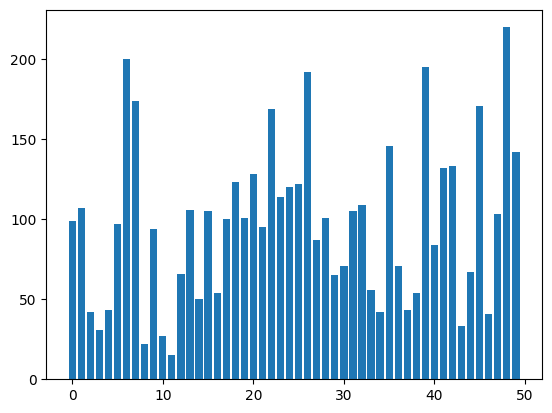

In [37]:
plt.bar(range(50),nb_label_wrongpred)
plt.show()

In [38]:
good_classification = []
bad_classification = []
for i in range(50):
    if nb_label_wrongpred[i]<=5:
        good_classification.append(i)
    if    nb_label_wrongpred[i]>=60:
        bad_classification.append(i)

In [39]:
def find_right_animal(m):
    wrong_pred_m =[]
    for j in [i for i,x in enumerate(right_label) if x == m]:
        wrong_pred_m.append(wrong_pred[j])
    return list_animal[max(wrong_pred_m,key = wrong_pred_m.count)]

In [40]:
for i in good_classification :
    print('Alexnet a bien classifie '+animals[i])

In [41]:
for i in bad_classification:
    print('Alexnet a mal classifie '+animals[i]+' , melange souvent avec '+find_right_animal(i))

Alexnet a mal classifie antelope , melange souvent avec deer
Alexnet a mal classifie grizzly+bear , melange souvent avec buffalo
Alexnet a mal classifie persian+cat , melange souvent avec hamster
Alexnet a mal classifie horse , melange souvent avec buffalo
Alexnet a mal classifie german+shepherd , melange souvent avec grizzly+bear
Alexnet a mal classifie siamese+cat , melange souvent avec hamster
Alexnet a mal classifie tiger , melange souvent avec leopard
Alexnet a mal classifie hippopotamus , melange souvent avec seal
Alexnet a mal classifie moose , melange souvent avec buffalo
Alexnet a mal classifie humpback+whale , melange souvent avec blue+whale
Alexnet a mal classifie elephant , melange souvent avec buffalo
Alexnet a mal classifie gorilla , melange souvent avec chimpanzee
Alexnet a mal classifie ox , melange souvent avec buffalo
Alexnet a mal classifie fox , melange souvent avec rabbit
Alexnet a mal classifie sheep , melange souvent avec horse
Alexnet a mal classifie seal , mela

In [42]:
anno = pd.read_csv("annotations.csv",header=None)[1]

In [43]:
anno_list =list(anno)

In [44]:
for animal in animals:
    print("Il y a " + str(anno_list.count(animal)) +" "+ animal  )

Il y a 1046 antelope
Il y a 852 grizzly+bear
Il y a 291 killer+whale
Il y a 193 beaver
Il y a 549 dalmatian
Il y a 747 persian+cat
Il y a 1645 horse
Il y a 1033 german+shepherd
Il y a 174 blue+whale
Il y a 500 siamese+cat
Il y a 188 skunk
Il y a 100 mole
Il y a 877 tiger
Il y a 684 hippopotamus
Il y a 720 leopard
Il y a 704 moose
Il y a 291 spider+monkey
Il y a 709 humpback+whale
Il y a 1038 elephant
Il y a 872 gorilla
Il y a 728 ox
Il y a 664 fox
Il y a 1420 sheep
Il y a 988 seal
Il y a 728 chimpanzee
Il y a 779 hamster
Il y a 1200 squirrel
Il y a 696 rhinoceros
Il y a 1088 rabbit
Il y a 383 bat
Il y a 1202 giraffe
Il y a 589 wolf
Il y a 567 chihuahua
Il y a 310 rat
Il y a 272 weasel
Il y a 758 otter
Il y a 895 buffalo
Il y a 1170 zebra
Il y a 874 giant+panda
Il y a 1344 deer
Il y a 630 bobcat
Il y a 713 pig
Il y a 1019 lion
Il y a 185 mouse
Il y a 868 polar+bear
Il y a 1028 collie
Il y a 215 walrus
Il y a 512 raccoon
Il y a 1338 cow
Il y a 946 dolphin


### Conclusion ###

Alexnet a une très bien performance en classification des animaux. Mais il a même la difficulté à classifer deux animaux similaires.
À faire:
1.Étudier si VIT a une meilleure performance à classifer deux animaux similaire.
2.Essayer de comprendre la logique de la construction de AlexNet